# Fit Missing Mass Squared Distributions

In [1]:
import array
import ROOT

ROOT.gStyle.SetOptFit(True)
ROOT.gStyle.SetHistMinimumZero(True);

COV_MATRIX_STATUS_CODE = {
  0 : "not calculated",
  1 : "approximated",
  2 : "made positive definite",
  3 : "accurate"
}

Welcome to JupyROOT 6.24/04


## Load files and get input histograms for the 3 cases

In [2]:
particle = "Pi-"
# particle = "Pi+"
# particle = "Proton"
rebinFactor = 35 if particle == "Proton" else 40;
inFileName = f"~/Analysis/ProtonTrackEfficiency/pmatt/trackeff_{particle}_4pi.root"
# inFileName = f"~/Analysis/ProtonTrackEfficiency/pmatt/trackeff_{particle}_2pi.root"
histNames = {
  "Total"   : "MissingMass/MissingMassVsBeamEnergy",
  "Found"   : "MissingMass/MissingMassVsBeamEnergy_Found",
  "Missing" : "MissingMass/MissingMassVsBeamEnergy_Missing"}
inFile = ROOT.TFile(inFileName)
MM2vsBeamEnergyHists = {case : inFile.Get(histName) for (case, histName) in histNames.items()}

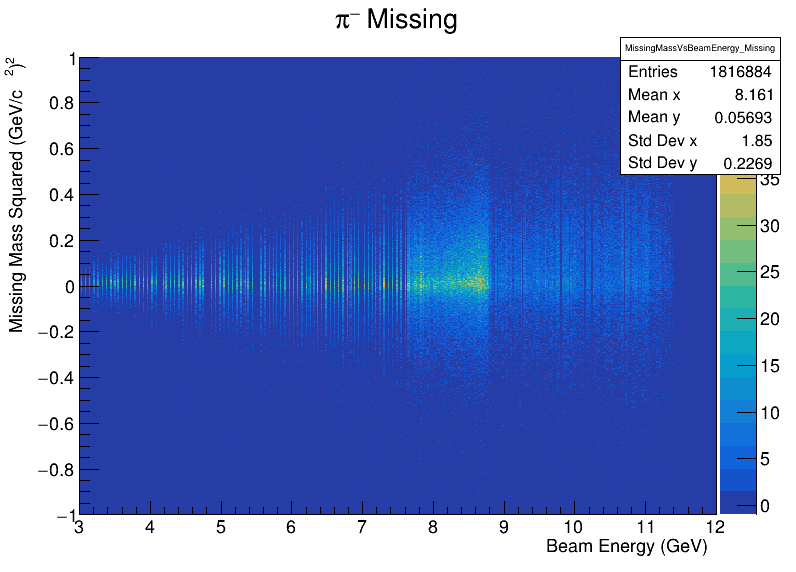

In [3]:
canv = ROOT.TCanvas("canv", "", 800, 600)
MM2vsBeamEnergyHists["Missing"].Draw("COLZ")
canv.Draw()

## Tracking efficiency from overall missing mass squared distributions

### Get missing overall mass squared distributions by projecting the 2D histograms and adjust binning

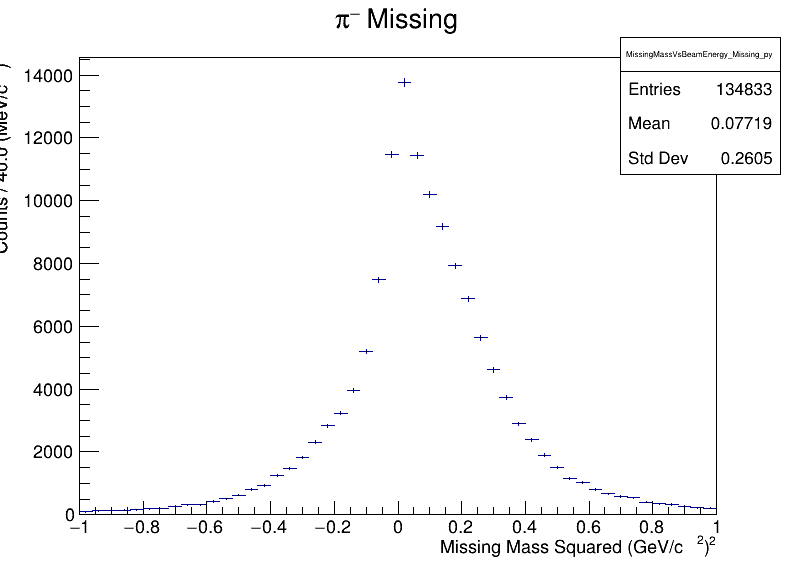

In [4]:
MM2Hists = {case : MM2vsBeamEnergyHist.ProjectionY() for (case, MM2vsBeamEnergyHist) in MM2vsBeamEnergyHists.items()}
# MM2Hists = {case : MM2vsBeamEnergyHist.ProjectionY(f"{MM2vsBeamEnergyHist.GetName()}_py",
#     MM2vsBeamEnergyHist.GetXaxis().FindBin(9), MM2vsBeamEnergyHist.GetXaxis().FindBin(10))
#   for (case, MM2vsBeamEnergyHist) in MM2vsBeamEnergyHists.items()}
for MM2Hist in MM2Hists.values():
  MM2Hist.Rebin(rebinFactor)
  MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1) * 1000}" + " (MeV/c^{2})^{2}")
MM2Hists["Missing"].Draw()
canv.Draw()

### Function that fits a missing mass squared distribution with a double Gaussian on top of a 2nd-order polynomial

In [5]:
# define fit function
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gROOT.LoadMacro("./doubleGaussianPol2.C+")
# Python callables need to exits in scope where where fit functions are drawn
doubleGaussianPol2 = ROOT.doubleGaussianPol2()
signal = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.signal)
gaussian1 = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.gaussian1)
gaussian2 = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.gaussian2)
background = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.background)

# fit function to distribution
def fitMissingMassSquared(MM2Hist, particle, fitRange = None, fixParValues = None, forceCommonGaussianMean = False):
  print(f"Fitting histogram '{MM2Hist.GetName()}', '{MM2Hist.GetTitle()}'")
  # construct fit function and set start parameters
  if fitRange is None:
    fitRange  = (MM2Hist.GetXaxis().GetXmin(), MM2Hist.GetXaxis().GetXmax())
  doubleGaussianPol2._forceCommonGaussianMean = forceCommonGaussianMean
  fitFunc = ROOT.TF1("doubleGaussianPol2", doubleGaussianPol2, fitRange[0], fitRange[1], 8 if forceCommonGaussianMean else 9)
  fitParameters = (("p_{0}", "p_{1}", "p_{2}", "A", "r", "#sigma_{1}", "#sigma_{2}", "#mu") if forceCommonGaussianMean
    else ("p_{0}", "p_{1}", "p_{2}", "A", "r", "#sigma_{1}", "#sigma_{2}", "#mu_{1}", "#mu_{2}"))
  fitFunc.SetParNames(*fitParameters)

  # ROOT.Math.MinimizerOptions().SetDefaultTolerance(0.001)
  # ROOT.Math.MinimizerOptions().SetMaxFunctionCalls(100000)
  # ROOT.Math.MinimizerOptions().SetDefaultPrintLevel(3)
  ROOT.TVirtualFitter.SetMaxIterations(100000)

  # first fitting stage: use single Gaussian on top of pol0
  if particle == "Proton":
    meanStartVal = 0.9383**2  # (proton mass)^2 [GeV^2]
    widthStartVal = 1.0       # [GeV^2]
  else:
    meanStartVal = 0.1396**2  # (pion mass)^2 [GeV^2]
    widthStartVal = 0.2       # [GeV^2]
  fitFunc.SetParameter("A", MM2Hist.Integral(MM2Hist.FindBin(fitRange[0]), MM2Hist.FindBin(fitRange[1])))
  fitFunc.SetParLimits(fitFunc.GetParNumber("A"), 0, 2 * fitFunc.GetParameter("A"))  # ensure positive parameter value
  fitFunc.FixParameter(fitFunc.GetParNumber("r"), 0)
  if forceCommonGaussianMean:
    fitFunc.SetParameter("#mu", meanStartVal)
  else:
    fitFunc.SetParameter("#mu_{1}", meanStartVal)
    fitFunc.FixParameter(fitFunc.GetParNumber("#mu_{2}"), meanStartVal)
  fitFunc.SetParameter("#sigma_{1}", widthStartVal)
  fitFunc.SetParLimits(fitFunc.GetParNumber("#sigma_{1}"), 0, 10)  # ensure positive parameter value
  fitFunc.FixParameter(fitFunc.GetParNumber("#sigma_{2}"), widthStartVal)
  fitFunc.SetParameter("p_{0}", 0)
  fitFunc.FixParameter(fitFunc.GetParNumber("p_{1}"), 0)
  fitFunc.FixParameter(fitFunc.GetParNumber("p_{2}"), 0)
  # MM2Hist.Fit(fitFunc, "WLRQN")
  MM2Hist.Fit(fitFunc, "RQN")

  # second fitting stage: use double Gaussian on top of pol0
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("r"))
  fitFunc.SetParameter("r", 0.5)  # nudge it, otherwise it does not move from zero
  if not forceCommonGaussianMean:
    fitFunc.ReleaseParameter(fitFunc.GetParNumber("#mu_{2}"))
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("#sigma_{2}"))
  fitFunc.SetParLimits(fitFunc.GetParNumber("#sigma_{2}"), 0, 10)  # ensure positive parameter value
  # MM2Hist.Fit(fitFunc, "WLRQN")
  MM2Hist.Fit(fitFunc, "RQN")

  # third fitting stage: use double Gaussian on top of pol2
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("p_{1}"))
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("p_{2}"))
  # fitResult = MM2Hist.Fit(fitFunc, "WLRIMSN")
  # fitResult = MM2Hist.Fit(fitFunc, "REIMSN")
  fitResult = MM2Hist.Fit(fitFunc, "REMSN")

  # fit recovery procedure
  maxNmbRefitAttempts = 5
  nmbRefitAttempts = 0
  while ((not fitResult.IsValid() or COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()] != "accurate")
          and nmbRefitAttempts < maxNmbRefitAttempts):
    nmbRefitAttempts += 1
    print(f"Fit did not converge. Performing refit attempt #{nmbRefitAttempts} of {maxNmbRefitAttempts}.")
    # fitResult = MM2Hist.Fit(fitFunc, "WLRIMSN")
    fitResult = MM2Hist.Fit(fitFunc, "REMSN")

  # add components of fit model to LoF of histogram
  fitFunc.SetLineColor(ROOT.kRed + 1)
  fitFunc.SetNpx(1000)
  MM2Hist.GetListOfFunctions().Add(fitFunc)
  signal._forceCommonGaussianMean = forceCommonGaussianMean
  sigFunc = ROOT.TF1("signal", signal, fitRange[0], fitRange[1], 9)
  sigFunc.SetLineColor(ROOT.kGreen + 2)
  gaussian1._forceCommonGaussianMean = forceCommonGaussianMean
  gauss1Func = ROOT.TF1("gaussian1", gaussian1, fitRange[0], fitRange[1], 9)
  gauss1Func.SetLineStyle(ROOT.kDashed)
  gauss1Func.SetLineColor(ROOT.kGreen + 2)
  gaussian2._forceCommonGaussianMean = forceCommonGaussianMean
  gauss2Func = ROOT.TF1("gaussian2", gaussian2, fitRange[0], fitRange[1], 9)
  gauss2Func.SetLineStyle(ROOT.kDashed)
  gauss2Func.SetLineColor(ROOT.kGreen + 2)
  background._forceCommonGaussianMean = forceCommonGaussianMean
  bgFunc = ROOT.TF1("background", background, fitRange[0], fitRange[1], 9)
  bgFunc.SetLineColor(ROOT.kBlue)
  components = (sigFunc, gauss1Func, gauss2Func, bgFunc)
  for func in components:
    func.SetNpx(1000)
    func.SetParNames(*fitParameters)
    func.SetParameters(fitFunc.GetParameters())
    MM2Hist.GetListOfFunctions().Add(func)

  fitResult.Print()
  print(f"reduced chi^2 = {fitResult.Chi2() / fitResult.Ndf()}; P-value = {fitResult.Prob()}")
  return fitResult

### Fit missing mass squared distributions for the 3 cases

In [6]:
fitResults = {case : fitMissingMassSquared(MM2Hist, particle, forceCommonGaussianMean = True) for (case, MM2Hist) in MM2Hists.items()}

Fitting histogram 'MissingMassVsBeamEnergy_py', '#pi^{#minus}'
reduced chi^2 = 314.9317889296106; P-value = 0.0
Fitting histogram 'MissingMassVsBeamEnergy_Found_py', '#pi^{#minus} Found'
Fit did not converge. Performing refit attempt #1 of 5.
reduced chi^2 = 213.3957315869737; P-value = 0.0
Fitting histogram 'MissingMassVsBeamEnergy_Missing_py', '#pi^{#minus} Missing'
reduced chi^2 = 43.473157351279234; P-value = 0.0
 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V

 FCN=12910.5 FROM MINOS     STATUS=SUCCESSFUL     61 CALLS        3606 TOTAL
                     EDM=1.93127e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 


Total: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
Found: minimizer status = 4140, fit result is valid = True, covariance matrix status = accurate
Missing: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate


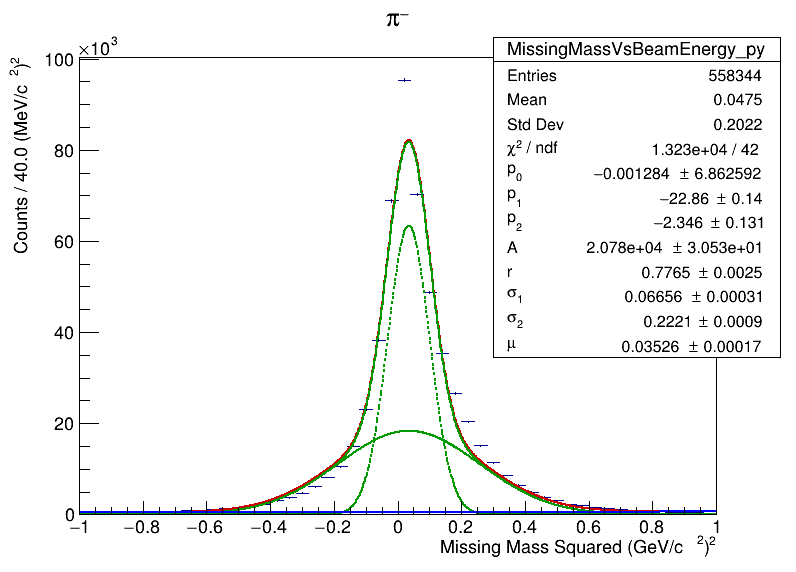

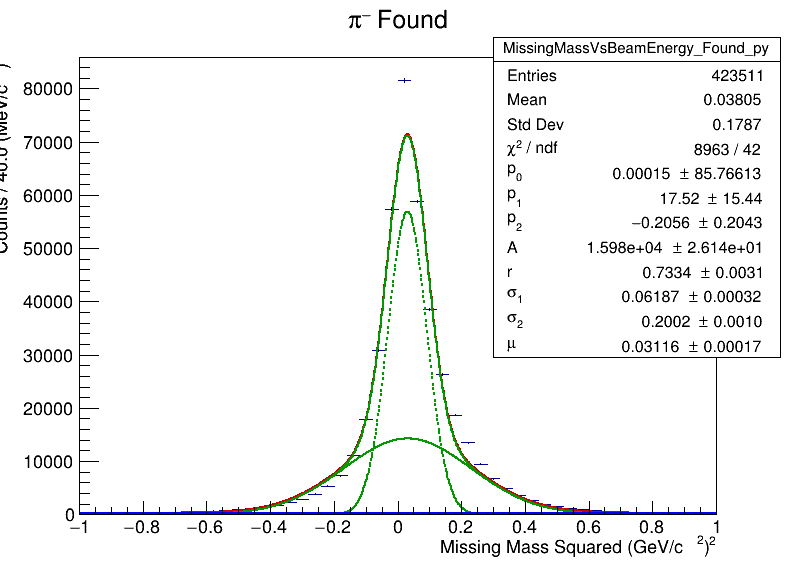

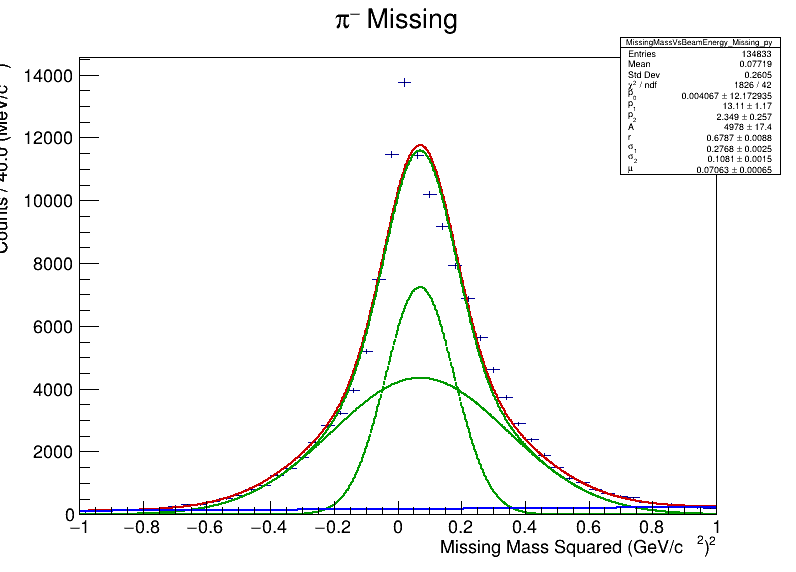

In [7]:
canvsOverall = {}
for case, MM2Hist in MM2Hists.items():
  canvsOverall[case] = ROOT.TCanvas(f"canv_{case}", "", 800, 600)
  MM2Hist.Draw()
  canvsOverall[case].Draw()
for case, fitResult in fitResults.items():
  print(
    f"{case}: "
    f"minimizer status = {fitResult.Status()}, "
    f"fit result is valid = {fitResult.IsValid()}, "
    f"covariance matrix status = {COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()]}"
  )

### Get overall signal yields and calculate average efficiency

In [8]:
def getSignalYield(fitResult):
  signalYield = fitResult.Parameter(fitResult.Index("A"))
  return signalYield

In [9]:
# assumes that 'fitResults' is dictionary with TFitResults for "Total", "Found", and "Missing"
def calculateEfficiency(fitResults):
  signalYields = {case : getSignalYield(fitResult) for (case, fitResult) in fitResults.items()}
  #TODO one could perform a combined fit of all 3 histograms enforcing Found + Missing == Total
  return signalYields["Found"] / (signalYields["Found"] + signalYields["Missing"])
signalYields = {case : getSignalYield(fitResult) for (case, fitResult) in fitResults.items()}
print(signalYields, f"mismatch = {100 * (signalYields['Total'] - signalYields['Found'] - signalYields['Missing']) / signalYields['Total']}%")
print(f"Overall efficiency = {100 * calculateEfficiency(fitResults)}%")
# {'Total': 216950.66785648285, 'Found': 133750.90614121358, 'Missing': 87366.35393304852} mismatch = -1.920525186184509%
# Overall efficiency = 60.4886774086715%

{'Total': 20780.28589423586, 'Found': 15975.970738211558, 'Missing': 4978.315080966221} mismatch = -0.8373317182810366%
Overall efficiency = 76.24201977616451%


## Tracking efficiencies as a function of beam energy from mass squared distributions

### Fit missing mass squared distributions in bins of beam energy

In [10]:
def getMissingMassSquaredBeamEnergyBins(MM2vsBeamEnergyHist,
                                        nmbBeamEnergyBins = 9,          # 1 GeV bin width
                                        beamEnergyRange = (3.0, 12.0),  # [GeV]
                                        minCounts = 1000):              # minimum number of counts required in bin
  energyBinWidth = (beamEnergyRange[1] - beamEnergyRange[0]) / float(nmbBeamEnergyBins)
  MM2Hists = {}
  for energyBin in range(nmbBeamEnergyBins):
    # get distribution for given beam energy bin
    energyBinMin = beamEnergyRange[0] + energyBin * energyBinWidth
    energyBinMax = energyBinMin + energyBinWidth
    MM2Hist = MM2vsBeamEnergyHist.ProjectionY(f"{MM2vsBeamEnergyHist.GetName()}_py_{energyBin}",
      MM2vsBeamEnergyHist.GetXaxis().FindBin(energyBinMin),
      MM2vsBeamEnergyHist.GetXaxis().FindBin(energyBinMax))
    MM2Hist.Rebin(rebinFactor)
    MM2Hist.SetTitle(f"{MM2vsBeamEnergyHist.GetTitle()}, {energyBinMin} < E_{{#gamma}} (GeV) < {energyBinMax}")
    MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1) * 1000} (MeV/c^{{2}})^{{2}}")
    counts = MM2Hist.Integral(1, MM2Hist.GetNbinsX())
    if  counts >= minCounts:
      MM2Hists[(energyBinMin, energyBinMax)] = MM2Hist
    else:
      print(f"Warning: {counts} counts in energy bin {(energyBinMin, energyBinMax)} are below the required minimum of {minCounts}. Skipping bin.")

  return MM2Hists

In [11]:
MM2HistsEBins = {case : getMissingMassSquaredBeamEnergyBins(MM2vsBeamEnergyHist) for (case, MM2vsBeamEnergyHist) in MM2vsBeamEnergyHists.items()}

In [12]:
def fitMissingMassSquaredBeamEnergyBins(MM2HistsEBins, particle, forceCommonGaussianMean = False):  # dictionary of dictionaries {case : {energy bin : histogram, ...}, ...}
  fitResults = {}
  for case, MM2Hists in MM2HistsEBins.items():
    fitResults[case] = {}
    for energyBin, MM2Hist in MM2Hists.items():
      # fit distribution
      print(f"Fitting case {case} for beam energy bin {energyBin} GeV")
      fitResults[case][energyBin] = fitMissingMassSquared(MM2Hist, particle, forceCommonGaussianMean = forceCommonGaussianMean)

  return fitResults

In [13]:
fitResultsEBins = fitMissingMassSquaredBeamEnergyBins(MM2HistsEBins, particle, forceCommonGaussianMean = True)

Fitting case Total for beam energy bin (3.0, 4.0) GeV
Fitting histogram 'MissingMassVsBeamEnergy_py_0', '#pi^{#minus}, 3.0 < E_{#gamma} (GeV) < 4.0'
reduced chi^2 = 31.388684743244912; P-value = 3.9093597457927665e-243
Fitting case Total for beam energy bin (4.0, 5.0) GeV
Fitting histogram 'MissingMassVsBeamEnergy_py_1', '#pi^{#minus}, 4.0 < E_{#gamma} (GeV) < 5.0'
reduced chi^2 = 64.697829968051; P-value = 0.0
Fitting case Total for beam energy bin (5.0, 6.0) GeV
Fitting histogram 'MissingMassVsBeamEnergy_py_2', '#pi^{#minus}, 5.0 < E_{#gamma} (GeV) < 6.0'
reduced chi^2 = 100.4404048776429; P-value = 0.0
Fitting case Total for beam energy bin (6.0, 7.0) GeV
Fitting histogram 'MissingMassVsBeamEnergy_py_3', '#pi^{#minus}, 6.0 < E_{#gamma} (GeV) < 7.0'
reduced chi^2 = 128.85435052684758; P-value = 0.0
Fitting case Total for beam energy bin (7.0, 8.0) GeV
Fitting histogram 'MissingMassVsBeamEnergy_py_4', '#pi^{#minus}, 7.0 < E_{#gamma} (GeV) < 8.0'
reduced chi^2 = 279.2768232250133; P-va

### Check whether fits converged

In [14]:
for case, fitResults in fitResultsEBins.items():
  for energyBin, fitResult in fitResults.items():
    print(
      f"case {case}, "
      f"energy bin {energyBin} GeV: "
      f"minimizer status = {fitResult.Status()}, "
      f"fit result is valid = {fitResult.IsValid()}, "
      f"covariance matrix status = {COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()]}"
    )

case Total, energy bin (3.0, 4.0) GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (4.0, 5.0) GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (5.0, 6.0) GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (6.0, 7.0) GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (7.0, 8.0) GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (8.0, 9.0) GeV: minimizer status = 4070, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (9.0, 10.0) GeV: minimizer status = 4000, fit result is valid = True, covariance matrix status = accurate
case Total, energy bin (10.0, 11.0) GeV: minimizer status = 4000, fit result is valid = True, covarianc

### Show fits

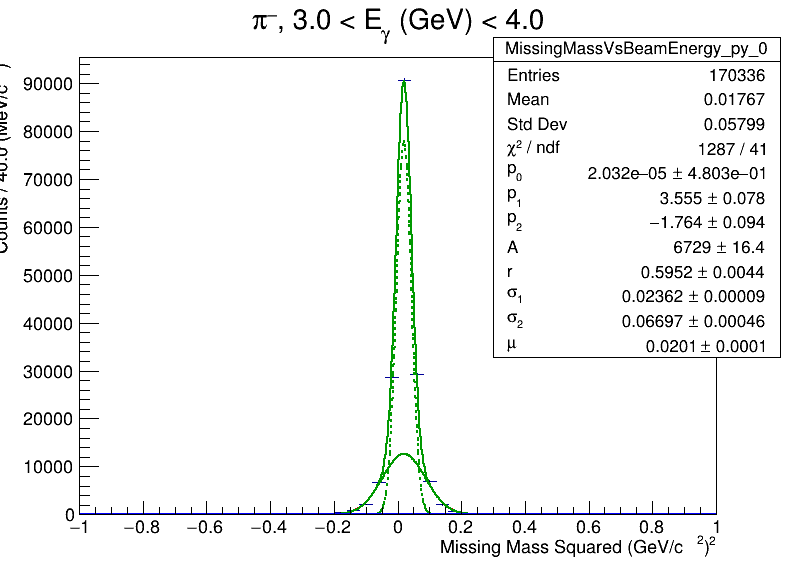

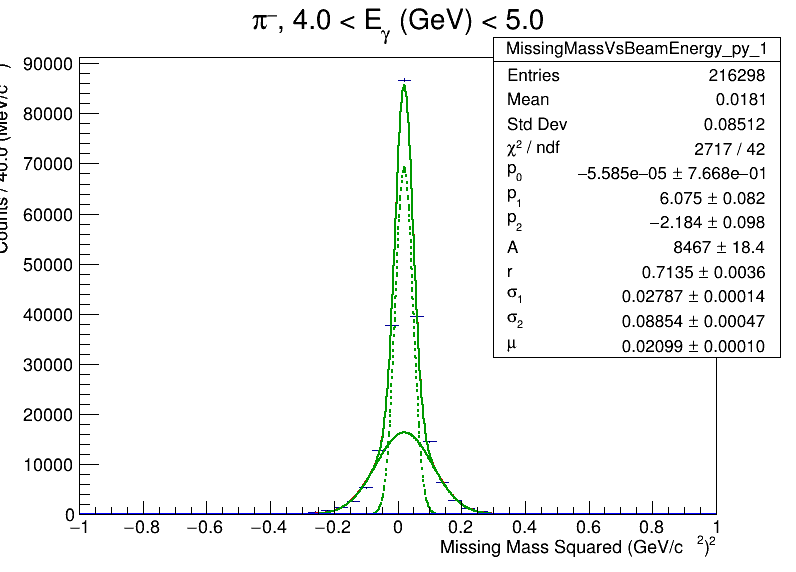

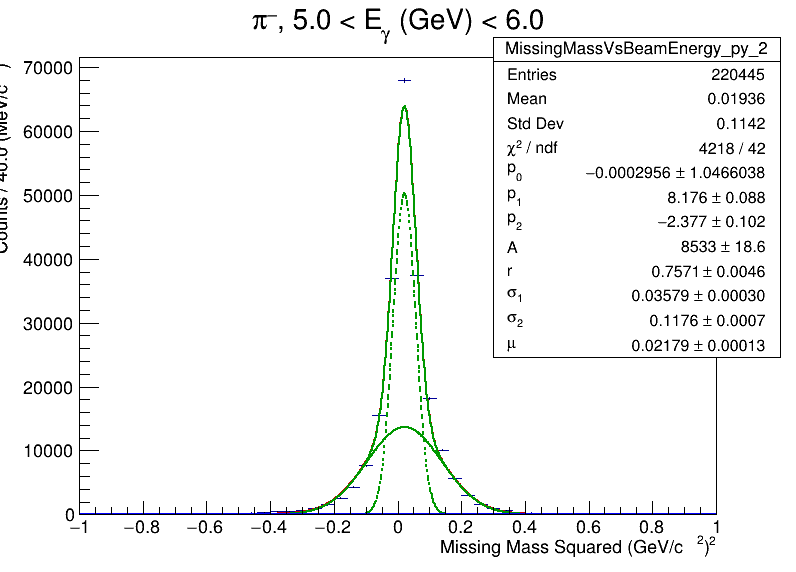

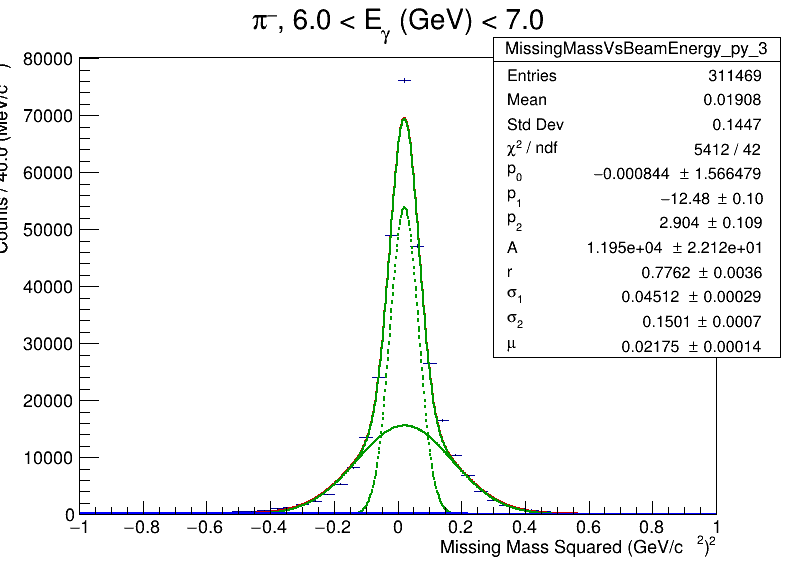

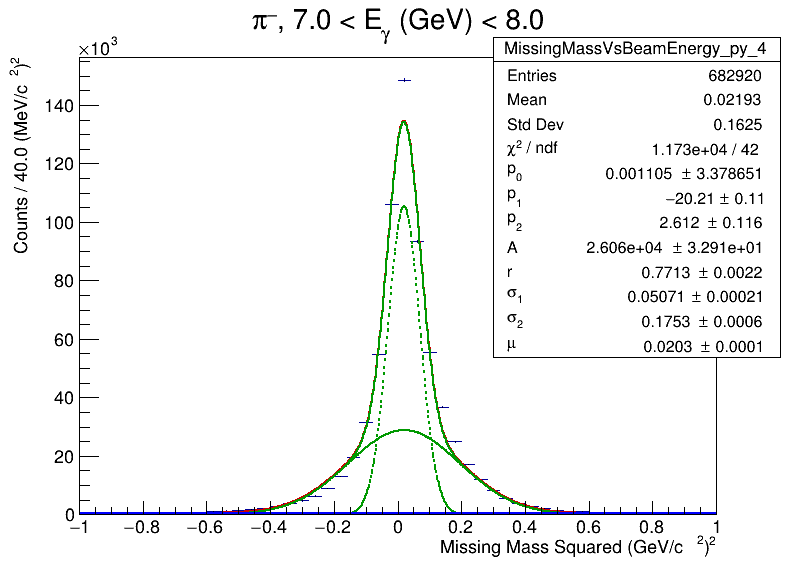

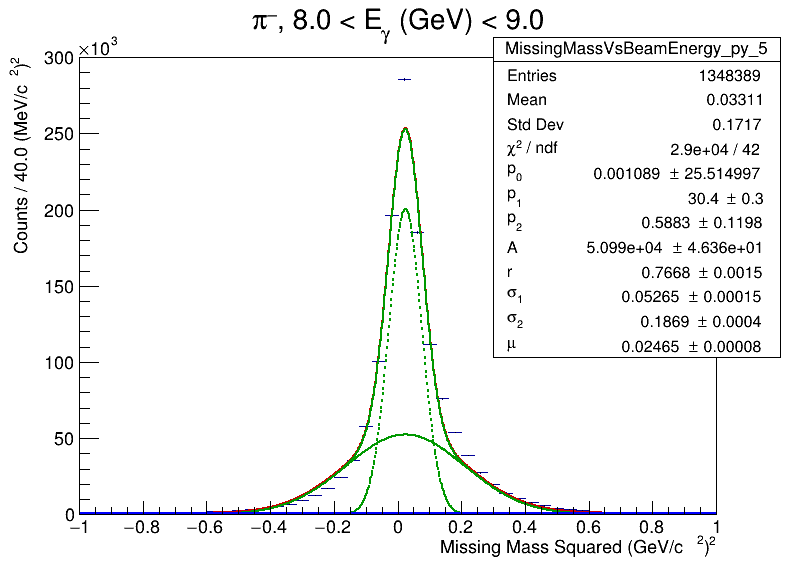

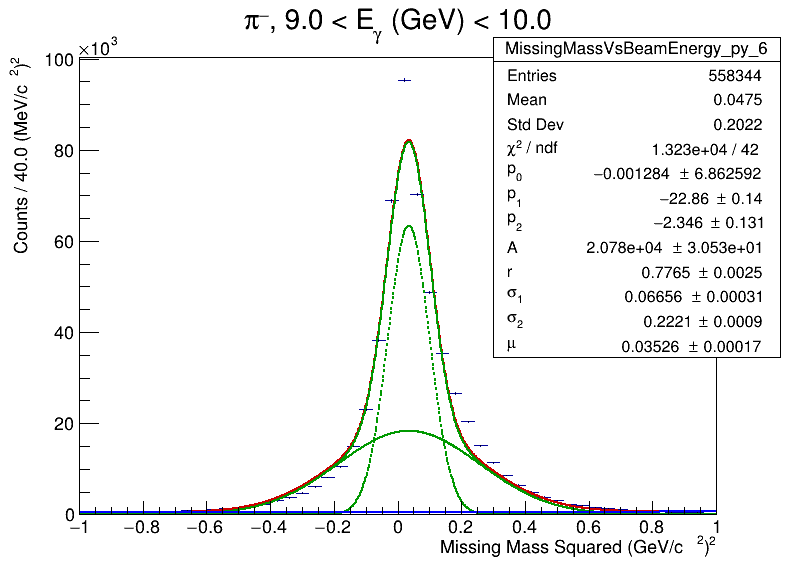

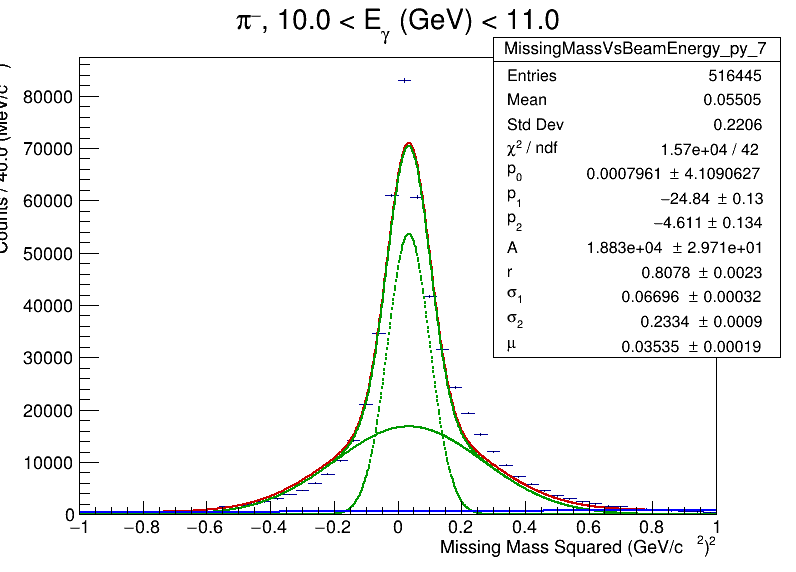

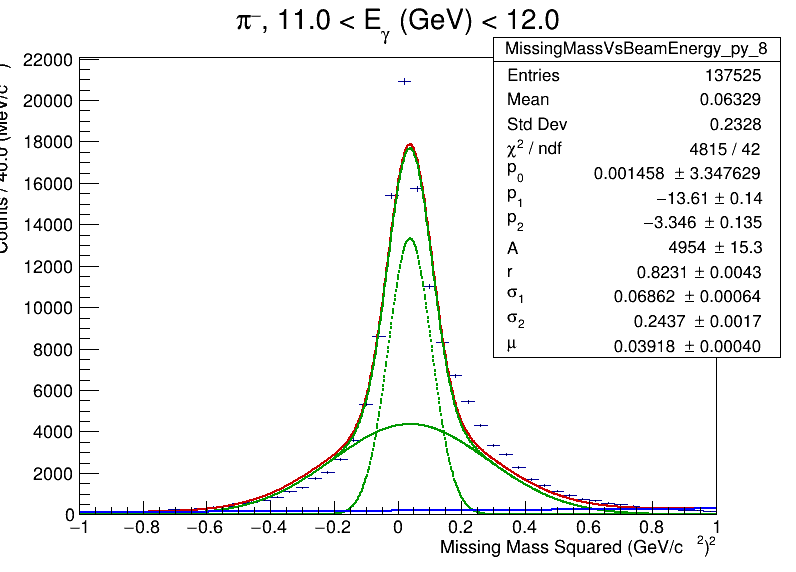

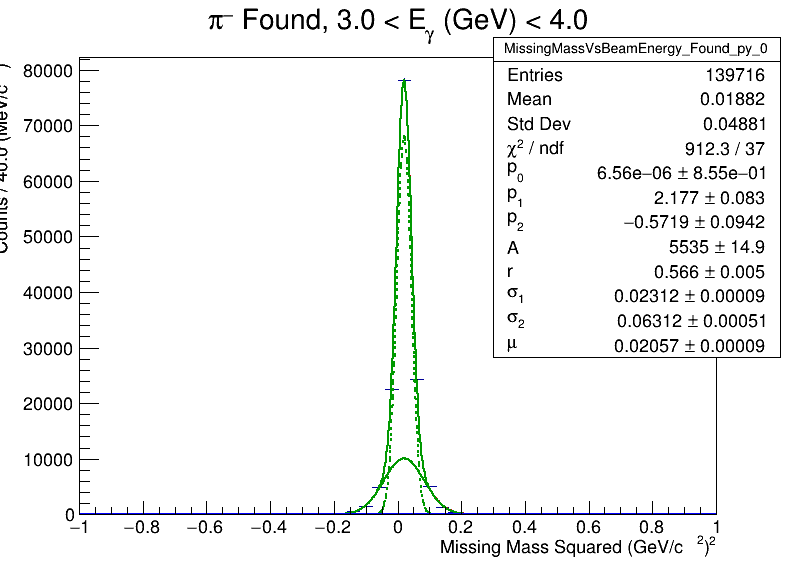

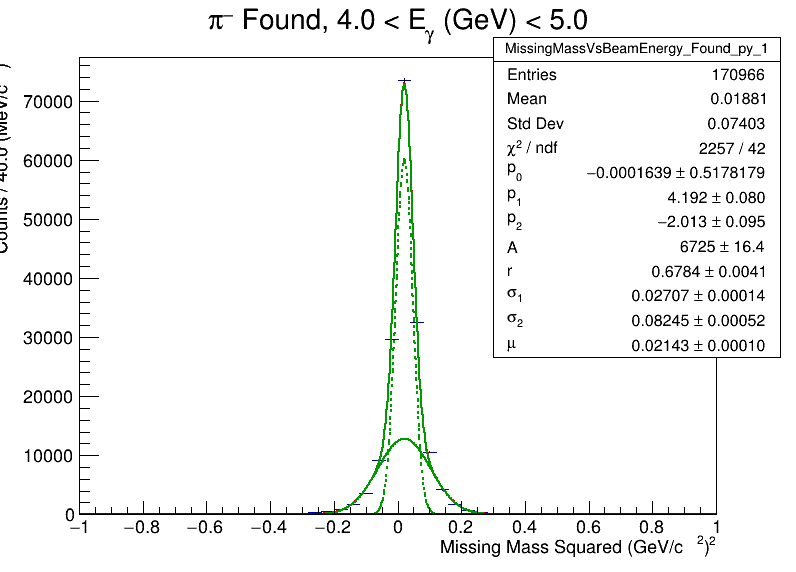

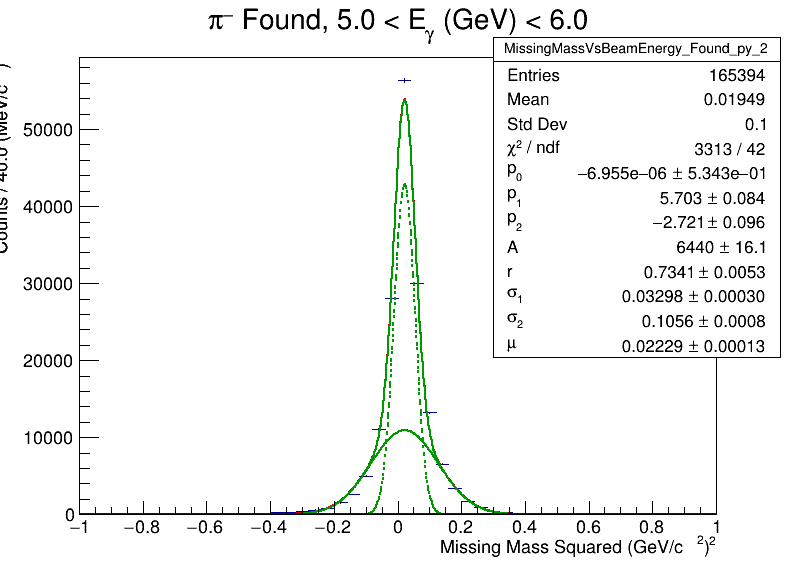

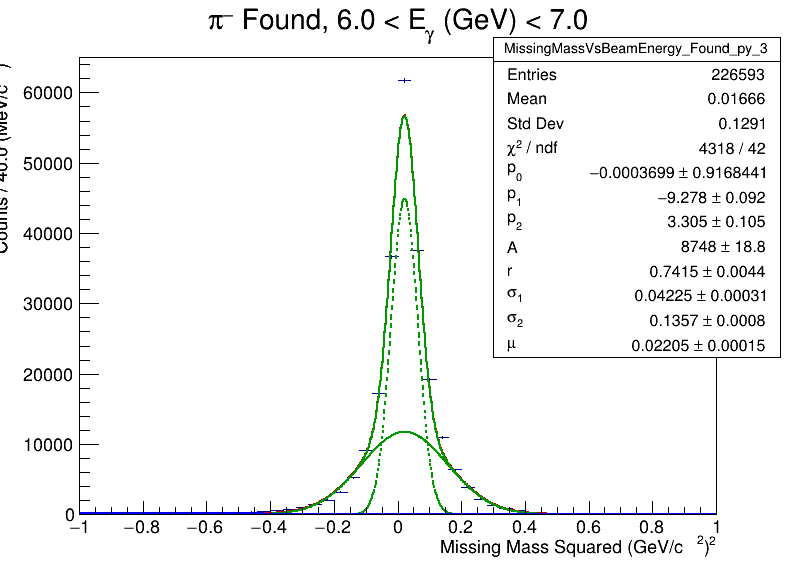

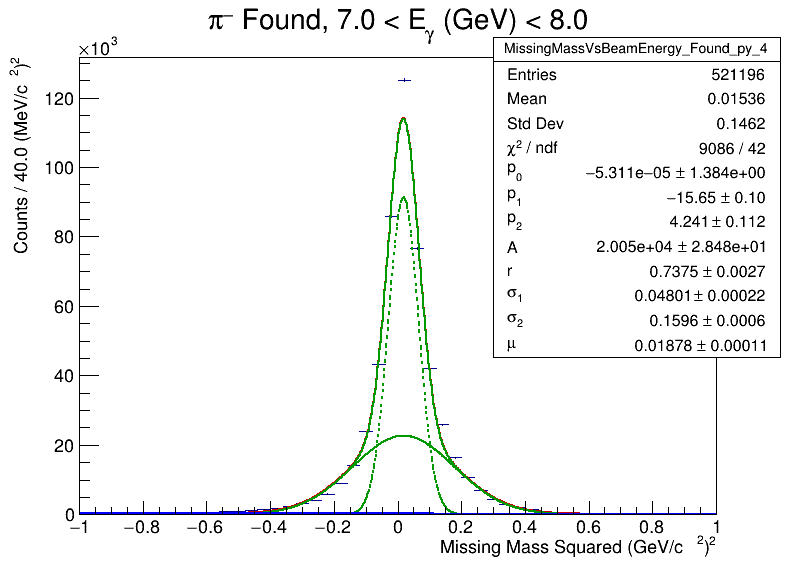

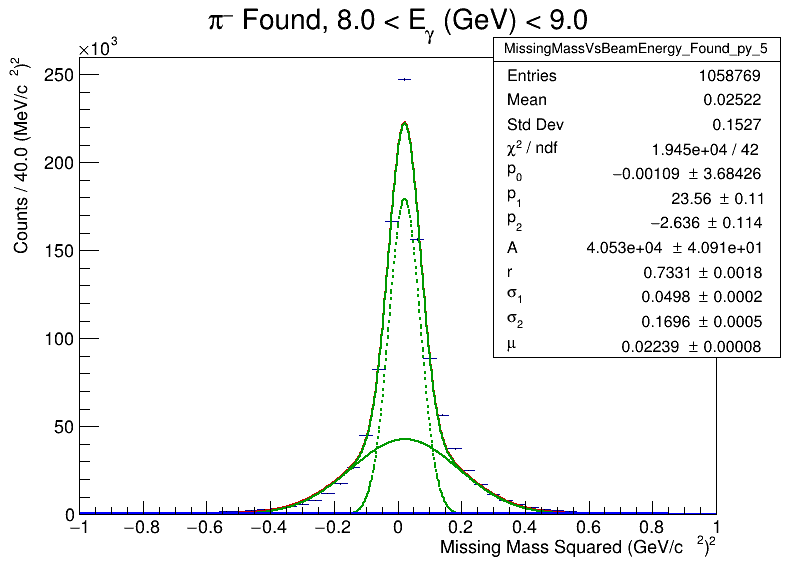

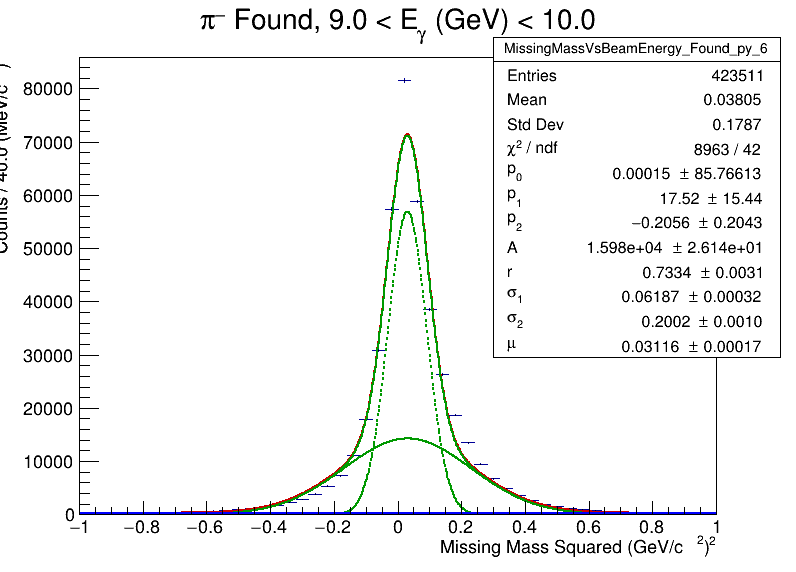

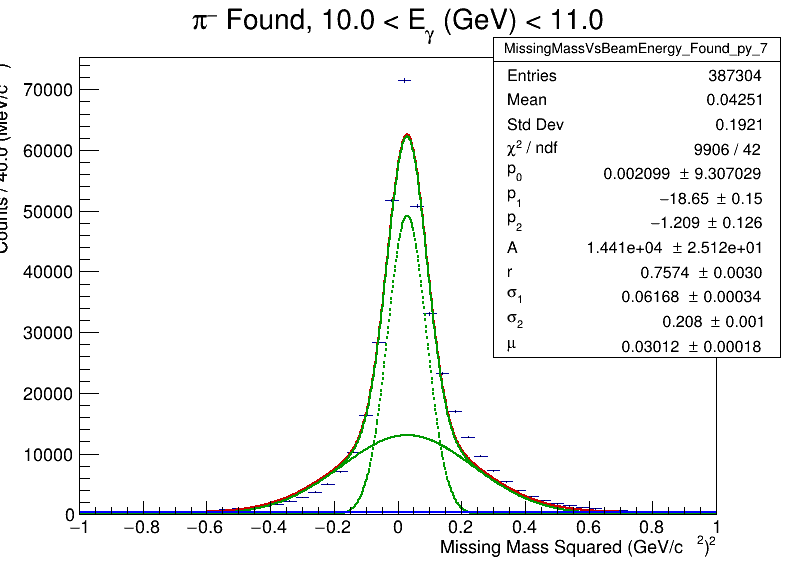

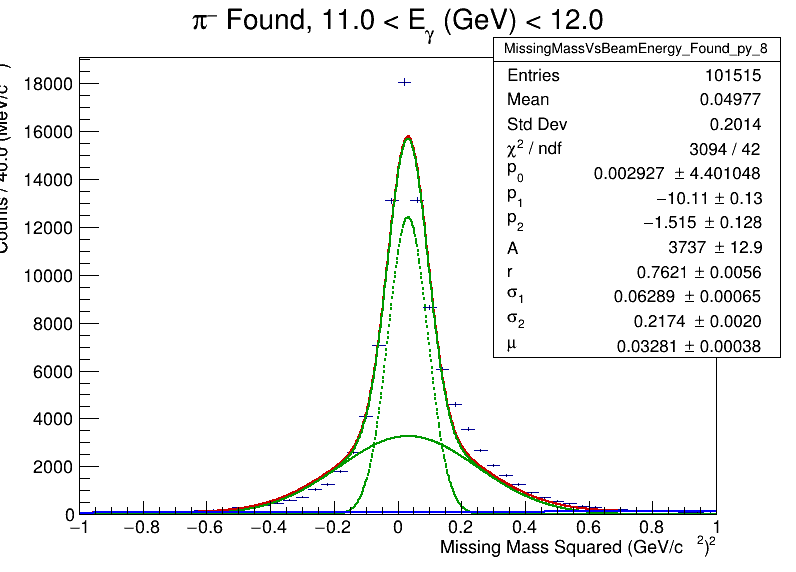

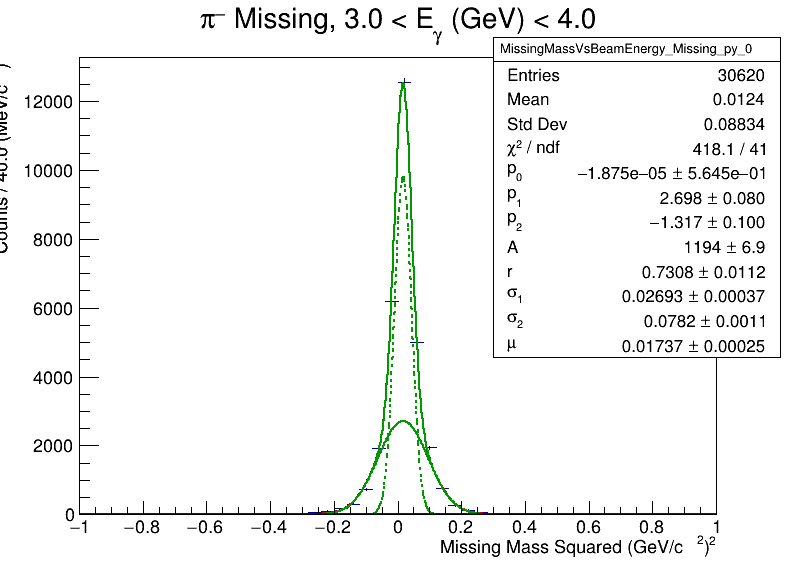

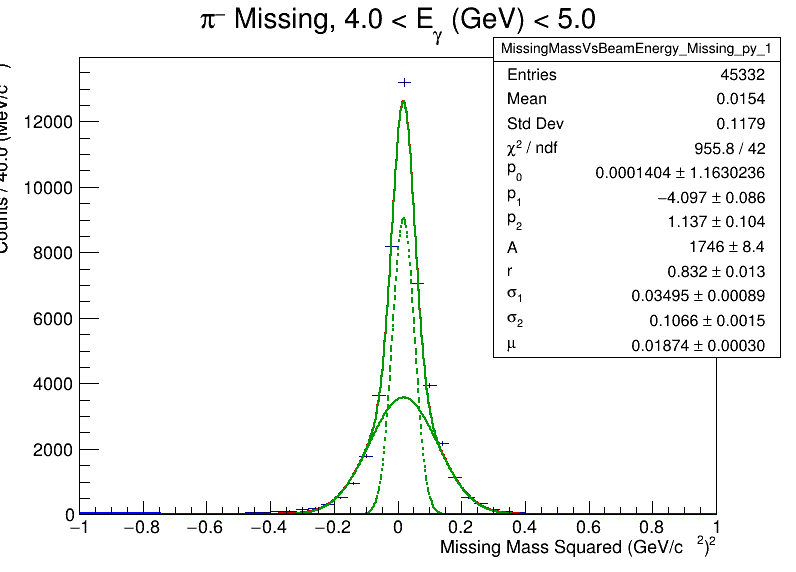

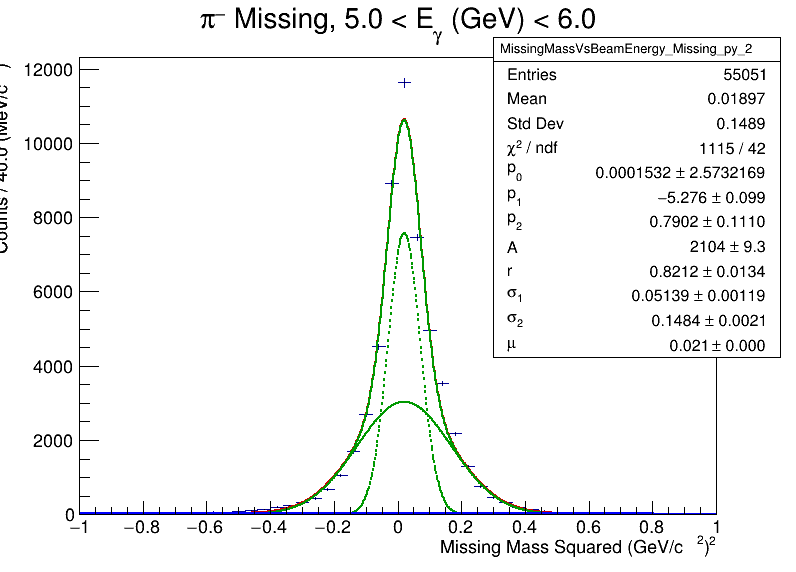

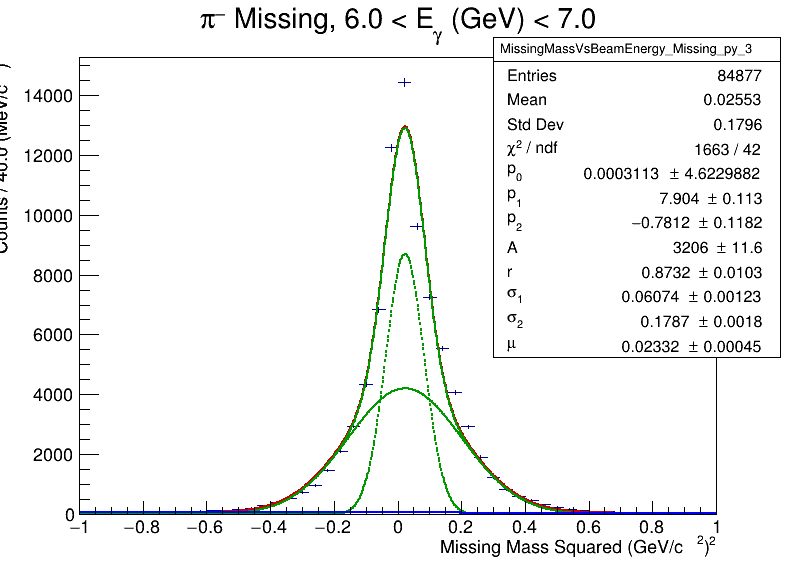

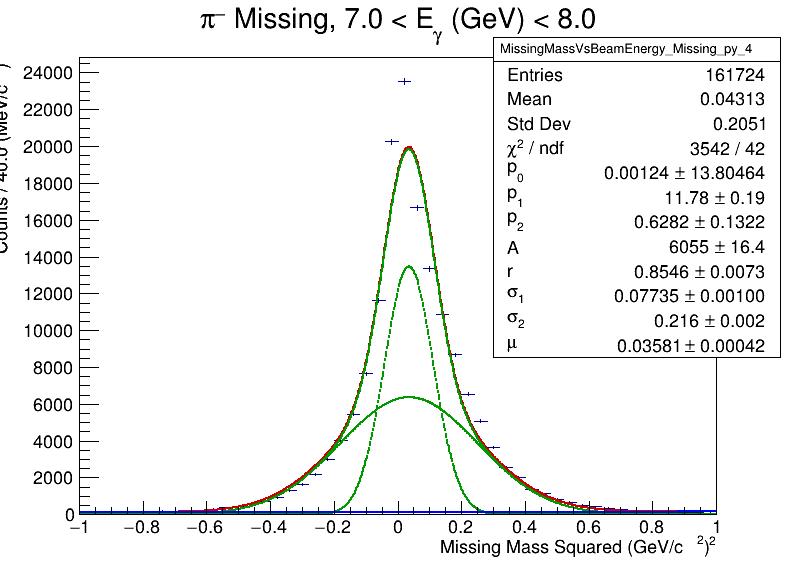

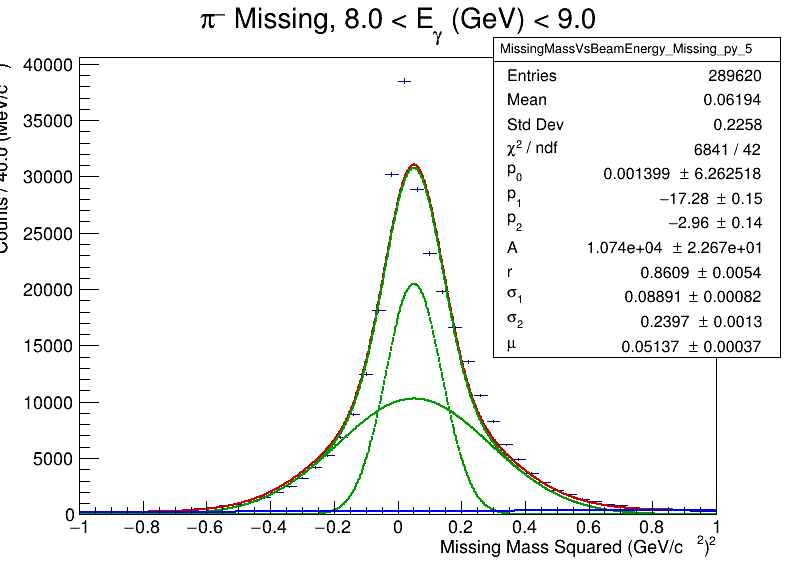

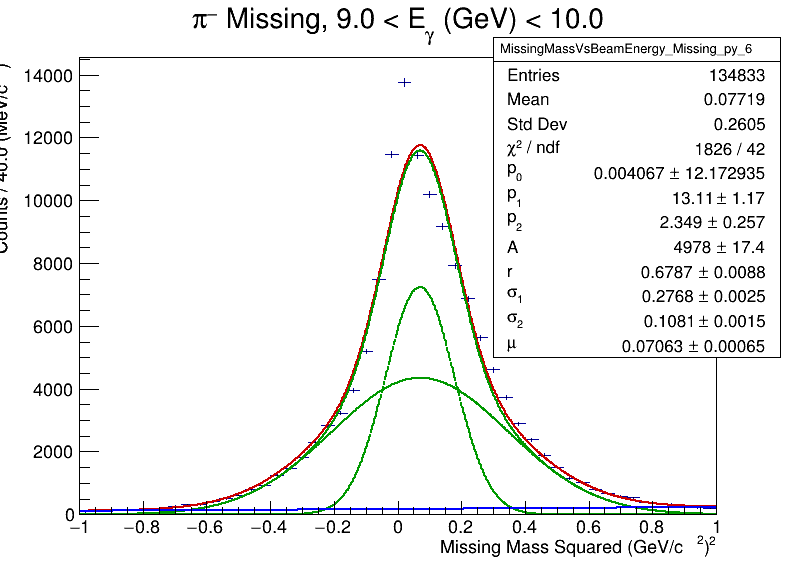

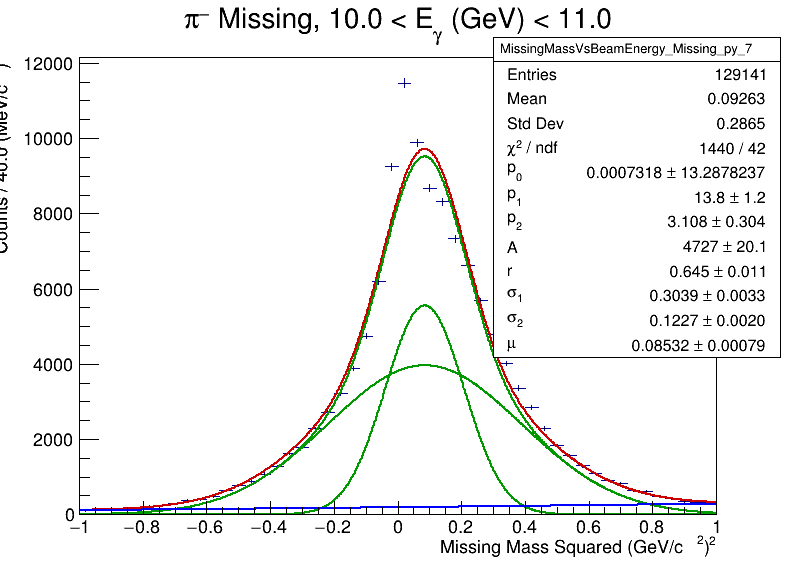

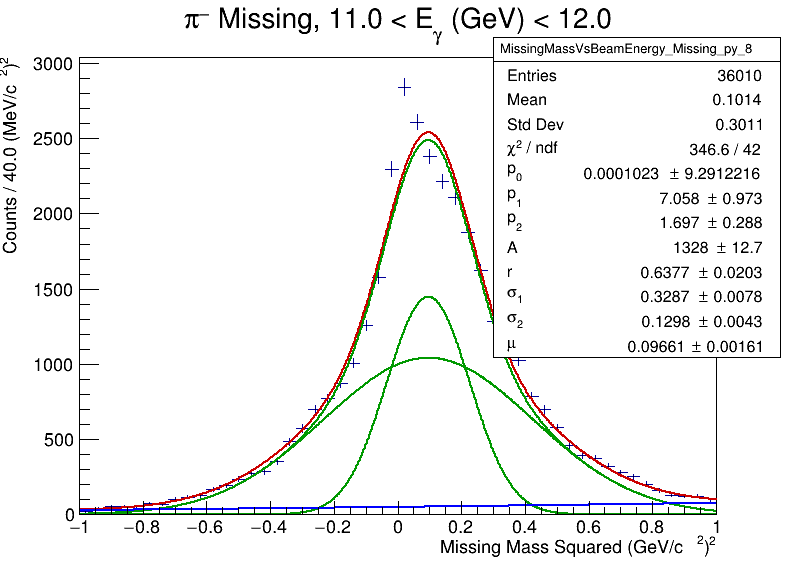

In [15]:
canvsEBins = {}
for case, MM2Hists in MM2HistsEBins.items():
  canvsEBins[case] = {}
  for energyBin, MM2Hist in MM2Hists.items():
    canvsEBins[case][energyBin] = ROOT.TCanvas(f"canv_{case}_{energyBin[0]}_{energyBin[1]}", "", 800, 600)
    MM2Hist.Draw()
    canvsEBins[case][energyBin].Draw()

### Calculate and plot efficiencies

In [16]:
efficienciesEBins = {}
for energyBin in fitResultsEBins["Total"].keys():
  cases = fitResultsEBins.keys()
  fitResults = {case : fitResultsEBins[case][energyBin] for case in cases}
  efficienciesEBins[energyBin] = calculateEfficiency(fitResults)
for energyBin, efficiency in efficienciesEBins.items():
  print(f"Efficiency in energy bin {energyBin} GeV = {100 * efficiency}%")

Efficiency in energy bin (3.0, 4.0) GeV = 82.26005118588321%
Efficiency in energy bin (4.0, 5.0) GeV = 79.39128143260567%
Efficiency in energy bin (5.0, 6.0) GeV = 75.37349399937244%
Efficiency in energy bin (6.0, 7.0) GeV = 73.18252069045568%
Efficiency in energy bin (7.0, 8.0) GeV = 76.80328074706378%
Efficiency in energy bin (8.0, 9.0) GeV = 79.04529775492871%
Efficiency in energy bin (9.0, 10.0) GeV = 76.24201977616451%
Efficiency in energy bin (10.0, 11.0) GeV = 75.29357519010806%
Efficiency in energy bin (11.0, 12.0) GeV = 73.77661863391818%


array('d', [3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5]) array('d', [0.8226005118588321, 0.7939128143260566, 0.7537349399937244, 0.7318252069045568, 0.7680328074706377, 0.7904529775492871, 0.7624201977616452, 0.7529357519010806, 0.7377661863391818])


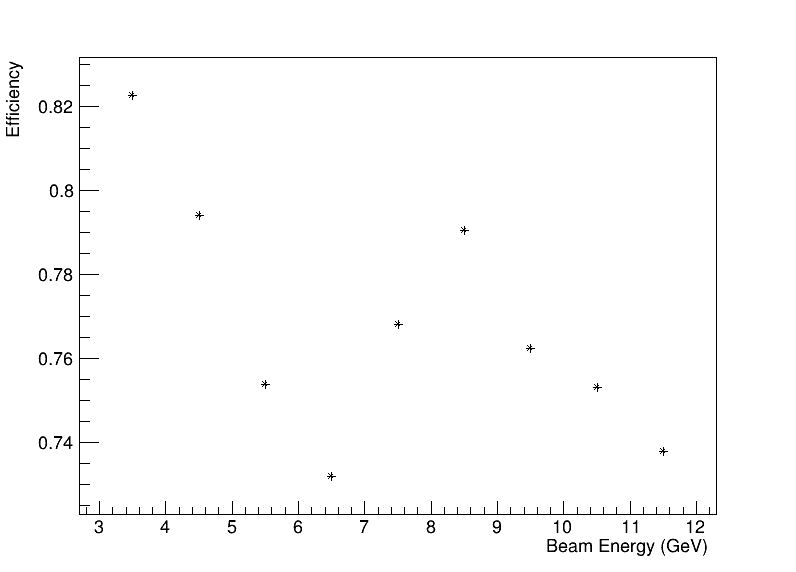

In [17]:
graphVals = [(0.5 * (energyBin[0] + energyBin[1]), efficiency) for (energyBin, efficiency) in efficienciesEBins.items()]
xVals = array.array('d', [graphVal[0] for graphVal in graphVals])
yVals = array.array('d', [graphVal[1] for graphVal in graphVals])
print(xVals, yVals)
efficienciesEBinsGraph = ROOT.TGraph(len(graphVals), xVals, yVals)
efficienciesEBinsGraph.SetTitle("")
efficienciesEBinsGraph.GetXaxis().SetTitle("Beam Energy (GeV)")
efficienciesEBinsGraph.GetYaxis().SetTitle("Efficiency")
canvEff = ROOT.TCanvas("canvEff", "", 800, 600)
efficienciesEBinsGraph.Draw("AP*")
canvEff.Draw()

# Scratchpad

In [ ]:
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gInterpreter.ProcessLine('''
struct MyFunction {
  MyFunction() { }

  double operator() (double* vars, double* pars)
  {
    const double x  = vars[0];
    const double p0 = pars[0];
    const double p1 = pars[1];
    const double p2 = pars[2];

    const double linTerm = p1 + p2 * x;
    return p0 * p0 + linTerm * linTerm;
  }
};
''')
myFunc = ROOT.MyFunction()
func = ROOT.TF1("func", myFunc, -1, 1, 3)
# make function visible in Cling's global scope so it can be used in TFormula
# see https://root-forum.cern.ch/t/advanced-tformula-and-tf1-usage/36643/2
ROOT.gInterpreter.ProcessLine("TF1& func = *((TF1*)gROOT->GetFunction(\"func\"))")
#!!! parameter setting in TFormula expression does not work
fooFunc = ROOT.TF1("fooFunc", "func(x)", -1, 1, 3)
fooFunc.SetParameter(0, -1)
fooFunc.SetParameter(1, -2)
fooFunc.SetParameter(2, -3)
# fooFunc = ROOT.TF1("fooFunc", "func(x, [2..4])", -1, 1, 5)
# fooFunc.SetParameter(0, 10)
# fooFunc.SetParameter(1, -5)
# fooFunc.SetParameter(2, -1)
# fooFunc.SetParameter(3, -2)
# fooFunc.SetParameter(4, -3)
# canv = ROOT.TCanvas("canv", "", 800, 600)
fooFunc.Draw()
canv.Draw()